In [1]:
import yfinance as yf
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller, coint
import statsmodels.api as sm
import pandas_ta as ta

from performance_indicator import *
from trading_computation import *
from plotting_computation import *

In [2]:
LEVERAGE = 10
INITIAL_CAP = 200000

## 1. Time Series Prep

- The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. It is often used when examining historical returns or doing a detailed analysis of past performance.

In [3]:
end_date = datetime(2019, 12, 31)
start_date = datetime(2014, 1, 1)

# Download data as dataframe
ETF = yf.download('SPTL', start=start_date, end=end_date).reset_index()
EFFR = web.DataReader('EFFR', 'fred', start_date, end_date).dropna().reset_index().rename({'DATE':'Date'}, axis = 1)

[*********************100%***********************]  1 of 1 completed


In [4]:
# The EFFR data will be Nan at weekends or some other federal holidays
# The weekends are not tradings days and hence they are dropped. Otherwise, use forward fill method
# Assuing the EFFR data to the same as the previous day
df = pd.merge(left = ETF, right = EFFR, on = 'Date', how = 'left').ffill(axis = 0)

df = df[['Date', 'Close', 'EFFR']]

In [5]:
df['EFFR'] = pd.to_numeric(df['EFFR'], errors='coerce')
# df['EFFR'] = df['EFFR'] / 100
# Adjust the annual risk-free rate to make it a daily rate
df['Daily_EFFR'] = df['EFFR']/(252*100)
df.head()

,Date,Close,EFFR,Daily_EFFR
0,2014-01-02,30.055,0.08,0.000003
1,2014-01-03,30.035,0.08,0.000003
2,2014-01-06,30.160,0.08,0.000003
3,2014-01-07,30.260,0.07,0.000003
4,2014-01-08,30.150,0.07,0.000003


In [6]:
# Calculate the daily execess return per unit SPTL
df['Daily_return'] = df['Close'].pct_change(1, fill_method='ffill')
df['Daily_excess_return'] = df['Close'].pct_change(1, fill_method='ffill') - df['Daily_EFFR']
df['Daily_excess_leverage_return'] = df['Daily_excess_return'] * LEVERAGE
df.iloc[196]

Date                            2014-10-13 00:00:00
Close                                     35.040001
EFFR                                           0.09
Daily_EFFR                                 0.000004
Daily_return                               0.005885
Daily_excess_return                        0.005881
Daily_excess_leverage_return               0.058814
Name: 196, dtype: object

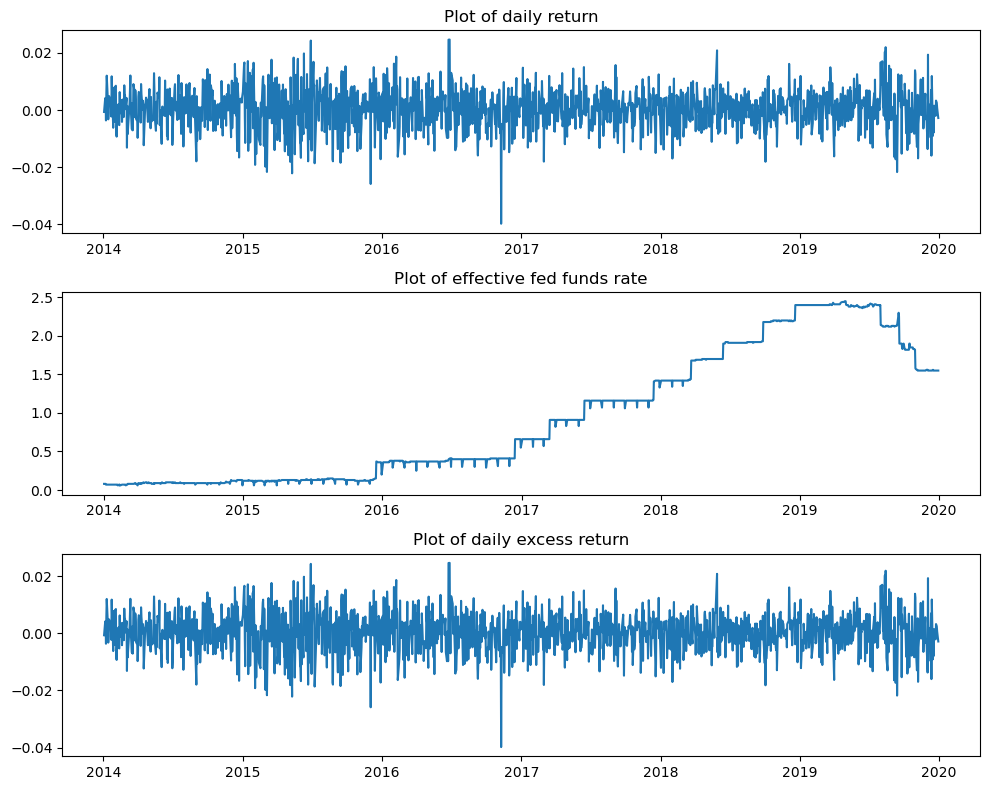

In [7]:
fig, ax = plt.subplots(3, 1, figsize = (10, 8))

ax[0].plot(df['Date'], df['Daily_return'])
ax[0].set_title('Plot of daily return')
ax[1].plot(df['Date'], df['EFFR'])
ax[1].set_title('Plot of effective fed funds rate')
ax[2].plot(df['Date'], df['Daily_excess_return'])
ax[2].set_title('Plot of daily excess return')
plt.tight_layout()

In [8]:
df

,Date,Close,EFFR,Daily_EFFR,Daily_return,Daily_excess_return,Daily_excess_leverage_return
0,2014-01-02,30.055000,0.08,0.000003,NaN,NaN,NaN
1,2014-01-03,30.035000,0.08,0.000003,-0.000665,-0.000669,-0.006686
2,2014-01-06,30.160000,0.08,0.000003,0.004162,0.004159,0.041586
3,2014-01-07,30.260000,0.07,0.000003,0.003316,0.003313,0.033129
4,2014-01-08,30.150000,0.07,0.000003,-0.003635,-0.003638,-0.036380
...,...,...,...,...,...,...,...
1504,2019-12-23,39.160000,1.55,0.000062,-0.002039,-0.002100,-0.021003
1505,2019-12-24,39.290001,1.55,0.000062,0.003320,0.003258,0.032582
1506,2019-12-26,39.389999,1.55,0.000062,0.002545,0.002484,0.024836
1507,2019-12-27,39.419998,1.55,0.000062,0.000762,0.000700,0.007001


## 2. Trading Strategies

### Strategy: LSTM Strategy

In [9]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import load_model

In [10]:
data = df.copy()
# Adding indicators
data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=50)

data.dropna(inplace=True)
data.reset_index(inplace = True)
dataset = data[['Close', 'RSI', 'EMAF', 'EMAM']]

In [11]:
dataset.head()

,Close,RSI,EMAF,EMAM
0,31.805000,60.627831,31.428095,31.179300
1,31.590000,54.966265,31.443515,31.195406
2,31.665001,56.485040,31.464609,31.213822
3,31.440001,50.960802,31.462265,31.222691
4,31.379999,49.575492,31.454430,31.228860


In [12]:
# Create a function to create a dataset with 60 timesteps
def create_dataset(dataset, time_step=60, y_colume_index=0):
    X, Y = [], []
    if not isinstance(dataset, np.ndarray):
        dataset = np.array(dataset).reshape(len(dataset), -1)

    if len(dataset.shape) == 1:
        dataset = dataset.reshape(-1, 1)
        
    # If we have 5 days of data and we want to look back 2 days
    # x1 = [d1, d2], y1 = [d3];
    # x2 = [d2, d3], y2 = [d4]; 
    # x3 = [d3, d4], y3 = [d5];
    for i in range(len(dataset) - time_step):
        
        # Slice from index i to index i + timestep, excluding (i + time_step)
        X.append(dataset[i:(i+time_step), :])
        Y.append(dataset[i + time_step, y_colume_index])
    return np.array(X), np.array(Y)


scalar = MinMaxScaler()
scaled_dataset = scalar.fit_transform(dataset)
# Create the dataset
time_step = 6
X, y = create_dataset(dataset, time_step, y_colume_index=0)

# The shape should be, (number of sequence, number of days to look back, number of columns)
print(X.shape)
print(y.shape)



(1454, 6, 4)
(1454,)


In [13]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1163, 6, 4)
(291, 6, 4)
(1163,)
(291,)


In [73]:

def train_lstm(seed):
    tf.random.set_seed(seed)
    # Build the LSTM model
    model = Sequential()
    # Return sequence: Boolean. Whether to return the last output in the output sequence, or the full sequence. Default: False.
    # Inputs: A 3D tensor, with shape (batch, timesteps, feature).
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

# model = train_lstm(seed = 10)
# model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)
# # model.save('models/lstm_v1.h5')

In [91]:
model = load_model('models/lstm_v1.h5')

y_pred_train = model.predict(X_train)
rmse = np.sqrt(np.mean((y_pred_train - y_train)**2))
print(f"Training Set -> Root Mean Squared Error: {rmse}")

y_pred_test = model.predict(X_test)
# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))
print(f"Testing Set -> Root Mean Squared Error: {rmse}")

2024-03-13 23:03:54.688826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-13 23:03:54.835404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-13 23:03:55.137263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 2s 15ms/step
Training Set -> Root Mean Squared Error: 2.5638513101823155
10/10 [==============================] - 0s 37ms/step
Testing Set -> Root Mean Squared Error: 3.577376070528241


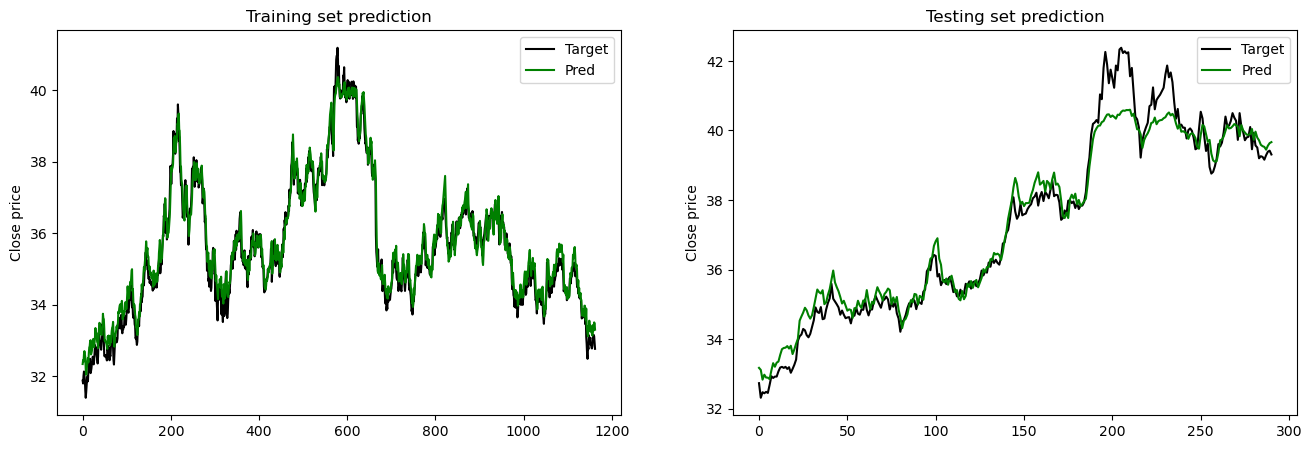

In [92]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].plot(y_train, color = 'black', label = 'Target')
ax[0].plot(y_pred_train, color = 'green', label = 'Pred')
ax[0].set_title('Training set prediction')
ax[0].set_ylabel('Close price')
ax[0].legend()

ax[1].plot(y_test, color = 'black', label = 'Target')
ax[1].plot(y_pred_test, color = 'green', label = 'Pred')
ax[1].set_title('Testing set prediction')
ax[1].set_ylabel('Close price')
ax[1].legend()
plt.show()

In [100]:
def buy_sell_threshold(current_price, predicted_price, threshold):
    # The backtest framework skips the first iteration
    Buy, Sell = [np.nan], [np.nan]

    for i in range(len(predicted_price)-1):
        if predicted_price[i] / current_price[i] - 1 > threshold:
            Buy.append(current_price[i])
            Sell.append(np.nan)
        elif predicted_price[i] / current_price[i] - 1 < - threshold:
            Sell.append(current_price[i])
            Buy.append(np.nan)
        else:
            Buy.append(np.nan)
            Sell.append(np.nan)
    return Buy, Sell

def generate_dynamic_signals(current_price, predictions, threshold=0.01):
    # Assuming predictions are normalized and centered around 0
    signals = np.zeros(len(predictions))

    for i in range(1, len(predictions)):
        change_percent = (predictions[i] / current_price[i] * 100) -1

        # if change_percent > threshold:
        if abs(change_percent) > threshold:
            # Signal strength is proportional to the change percent
            signals[i] = np.tanh(change_percent)
        else:
            signals[i] = 0
    
    return signals


In [102]:
strategy_data = pd.DataFrame(index=data.index)
strategy_data['Close'] = data['Close']
strategy_data['Date'] = data['Date']
strategy_data['Predictions'] = np.nan
strategy_data['Daily_EFFR'] = data['Daily_EFFR']
strategy_data['Daily_excess_return'] = data['Daily_excess_return'] 

strategy_data.iloc[time_step: time_step+len(y_pred_train), strategy_data.columns.get_loc('Predictions')] = y_pred_train.flatten()
strategy_data.iloc[len(X_train)+time_step:len(X_train)+time_step+len(y_pred_test),strategy_data.columns.get_loc('Predictions')] = y_pred_test.flatten()

strategy_data

,Close,Date,Predictions,Daily_EFFR,Daily_excess_return
0,31.805000,2014-03-14,NaN,0.000003,0.000311
1,31.590000,2014-03-17,NaN,0.000003,-0.006763
2,31.665001,2014-03-18,NaN,0.000003,0.002371
3,31.440001,2014-03-19,NaN,0.000003,-0.007109
4,31.379999,2014-03-20,NaN,0.000003,-0.001912
...,...,...,...,...,...
1455,39.160000,2019-12-23,39.528004,0.000062,-0.002100
1456,39.290001,2019-12-24,39.448524,0.000062,0.003258
1457,39.389999,2019-12-26,39.562721,0.000062,0.002484
1458,39.419998,2019-12-27,39.637440,0.000062,0.000700


In [96]:
strategy_data['Buy_Signal_Price'], strategy_data['Sell_Signal_Price'] = buy_sell_threshold(current_price = strategy_data['Close'], 
                                                                                           predicted_price = strategy_data['Predictions'], 
                                                                                           threshold = 0.02)
buy_signal = np.where(strategy_data['Buy_Signal_Price'] > 0, 1, 0)
sell_signal = np.where(strategy_data['Sell_Signal_Price'] > 0, -1, 0)
signal = buy_signal + sell_signal
strategy_data['Signal'] = signal
strategy_data

,Close,Date,Predictions,Daily_EFFR,Daily_excess_return,Buy_Signal_Price,Sell_Signal_Price,Signal
0,31.805000,2014-03-14,NaN,0.000003,0.000311,NaN,NaN,0
1,31.590000,2014-03-17,NaN,0.000003,-0.006763,NaN,NaN,0
2,31.665001,2014-03-18,NaN,0.000003,0.002371,NaN,NaN,0
3,31.440001,2014-03-19,NaN,0.000003,-0.007109,NaN,NaN,0
4,31.379999,2014-03-20,NaN,0.000003,-0.001912,NaN,NaN,0
...,...,...,...,...,...,...,...,...
1455,39.160000,2019-12-23,39.528004,0.000062,-0.002100,NaN,NaN,0
1456,39.290001,2019-12-24,39.448524,0.000062,0.003258,NaN,NaN,0
1457,39.389999,2019-12-26,39.562721,0.000062,0.002484,NaN,NaN,0
1458,39.419998,2019-12-27,39.637440,0.000062,0.000700,NaN,NaN,0


In [55]:
signal[:]

array([0, 0, 0, ..., 0, 0, 0])

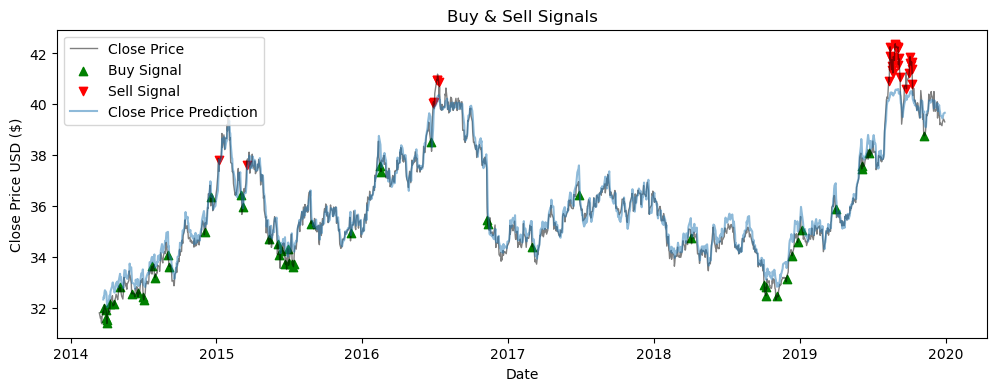

In [97]:
plot_signals(strategy_data=strategy_data, signal = signal)
plt.plot(strategy_data['Date'], strategy_data['Predictions'], label='Close Price Prediction', alpha=0.5)
plt.legend()

/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


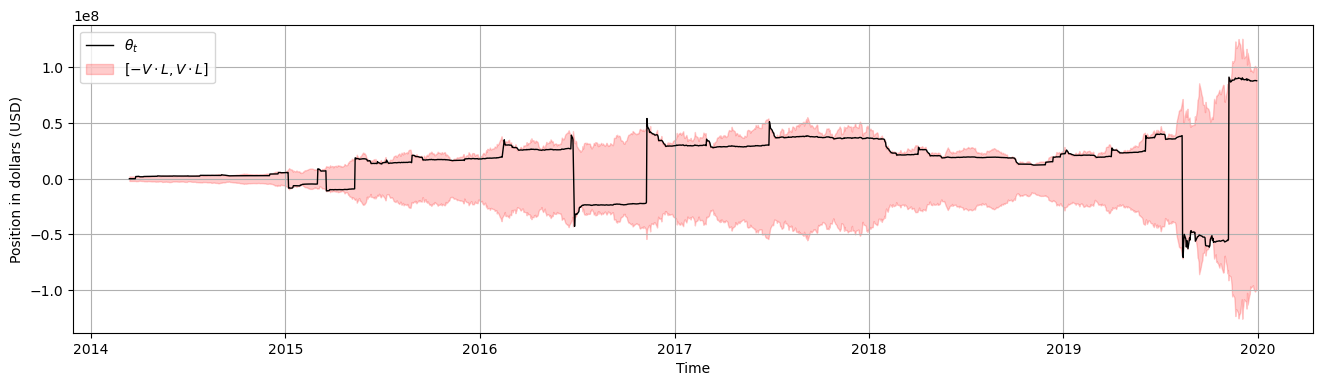

In [98]:
result = compute_position_value(df = strategy_data, 
                                signal = strategy_data['Signal'], 
                                initial_capital = INITIAL_CAP, 
                                max_leverage = LEVERAGE, 
                                reduced_leverage_shorting = False,
                                hold_at_signal_0 = True)
plot_position(strategy_data['Date'], result['theta'], result['Vtot'], LEVERAGE)


/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:84: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


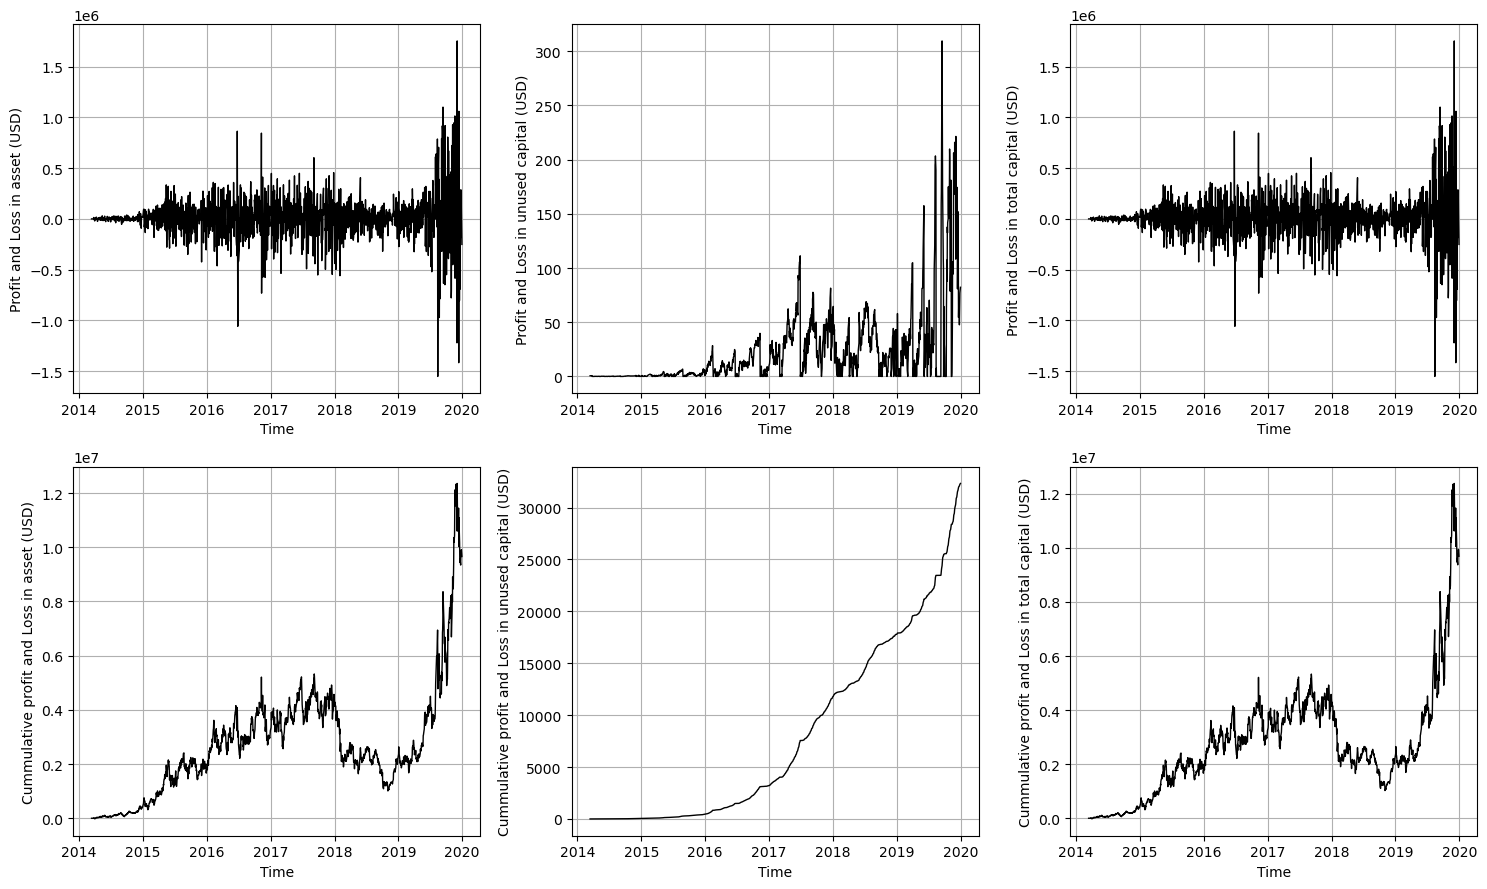

In [99]:
plot_PnL(strategy_data['Date'], result['dV'], result['dVcap'], result['dVtot'])

In [23]:
strategy_data

,Close,Date,Predictions,Daily_EFFR,Daily_excess_return,Buy_Signal_Price,Sell_Signal_Price,Signal
0,31.805000,2014-03-14,NaN,0.000003,0.000311,NaN,NaN,0
1,31.590000,2014-03-17,NaN,0.000003,-0.006763,NaN,NaN,0
2,31.665001,2014-03-18,NaN,0.000003,0.002371,NaN,NaN,0
3,31.440001,2014-03-19,NaN,0.000003,-0.007109,NaN,NaN,0
4,31.379999,2014-03-20,NaN,0.000003,-0.001912,NaN,NaN,0
...,...,...,...,...,...,...,...,...
1455,39.160000,2019-12-23,39.528004,0.000062,-0.002100,NaN,NaN,0
1456,39.290001,2019-12-24,39.448524,0.000062,0.003258,NaN,NaN,0
1457,39.389999,2019-12-26,39.562721,0.000062,0.002484,NaN,NaN,0
1458,39.419998,2019-12-27,39.637440,0.000062,0.000700,NaN,NaN,0


In [24]:
np.cumsum(np.diff(result['Vtot']))[-1]

-49350.00367850138

## 3. Get average model performance

In [ ]:
cum_pnl = []
cum_pnl_hold = []
best_profit = -np.inf
for iteration in range(5):
    model = train_lstm(seed = iteration)
    model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    strategy_data.iloc[time_step: time_step+len(y_pred_train), strategy_data.columns.get_loc('Predictions')] = y_pred_train.flatten()
    strategy_data.iloc[len(X_train)+time_step:len(X_train)+time_step+len(y_pred_test),strategy_data.columns.get_loc('Predictions')] = y_pred_test.flatten()
    strategy_data['Buy_Signal_Price'], strategy_data['Sell_Signal_Price'] = buy_sell_threshold(strategy_data['Close'], strategy_data['Predictions'], 0.02)
    buy_signal = np.where(strategy_data['Buy_Signal_Price'] > 0, 1, 0)
    sell_signal = np.where(strategy_data['Sell_Signal_Price'] > 0, -1, 0)
    signal = buy_signal + sell_signal
    strategy_data['Signal'] = signal
    result = compute_position_value(df = strategy_data, 
                                signal = strategy_data['Signal'], 
                                initial_capital = INITIAL_CAP, 
                                max_leverage = LEVERAGE, 
                                reduced_leverage_shorting = False,
                                hold_at_signal_0 = False)
    
    result_hold = compute_position_value(df = strategy_data, 
                            signal = strategy_data['Signal'], 
                            initial_capital = INITIAL_CAP, 
                            max_leverage = LEVERAGE, 
                            reduced_leverage_shorting = False,
                            hold_at_signal_0 = True)
    
    pnl = np.cumsum(np.diff(result['Vtot']))[-1]
    pnl_hold = np.cumsum(np.diff(result_hold['Vtot']))[-1]
    cum_pnl.append(pnl)
    cum_pnl_hold.append(pnl_hold)
    
    if pnl > best_profit:
        best_profit = pnl
        print(f'Model {iteration} achieves cumulative profit of {best_profit}')
        model.save(f'models/lstm_iteration_{iteration}.h5')
        
    if pnl_hold > best_profit:
        best_profit = pnl_hold
        print(f'Model {iteration} achieves cumulative profit of {best_profit}')
        model.save(f'models/lstm_iteration_{iteration}_hold.h5')
    
        
    

In [26]:
# print(f'Cumulative profit: {cum_pml}')
# print(f'Cumulative profit with reduced shorting leverage: {cum_pml_hold}')

In [27]:
# print(f'Mean cumulative profit: {np.mean(cum_pml):3f}')
# print(f'Mean cumulative profit with holding: {np.mean(cum_pml_hold):3f}')

In [90]:
cum_pnl_hold

[-199904.41094199917,
 -173523.67620185166,
 -156096.8193253969,
 -182390.25449676396,
 -33791.86752863703,
 -148023.65725965405,
 -185382.0785938457,
 -165917.91236101295,
 -199644.83526129907,
 -194158.0391943194,
 -186931.5558371945,
 -134267.168522214,
 -104861.24924818565,
 -167109.40949410162,
 -187128.95604553347,
 -115961.87049651021,
 -159668.66914375708,
 -199354.63303031595,
 -179531.2529578299,
 -192175.15198442116]